In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data_path = '../data/cleandata/train_Zip_onehot.csv'
df = pd.read_csv(data_path)
df['Zip_cluster_0'] = df['Zip_cluster_0'].apply(lambda x: 1 if x else 0)
df['Zip_cluster_1'] = df['Zip_cluster_1'].apply(lambda x: 1 if x else 0)
df.head(5)

,ID,YearBuilt,SqFt,Story,Acres,Baths,Fireplaces,Value,Zip_cluster_0,Zip_cluster_1
0,1,1990,2102,1.0,0.77,2.0,1,203200,0,0
1,2,1986,1740,1.5,0.06,3.0,1,119096,0,0
2,3,1955,795,1.0,0.30,1.0,0,71666,0,0
3,4,1983,1152,1.0,0.68,2.0,0,131103,0,0
4,6,1924,1829,1.5,0.25,3.0,1,496425,1,0


In [9]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X = df.drop(['Value'], axis=1)
y = df['Value']

In [67]:
# set seed
seed = np.random.randint(100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
rf = RandomForestRegressor(n_estimators=100, random_state=seed, max_depth=5)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rt = DecisionTreeRegressor(random_state=seed)
rt.fit(X_train, y_train)
y_pred_rt = rt.predict(X_test)

from sklearn.metrics import mean_squared_error
print('Random Forest RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('Decision Tree RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_rt)))


Random Forest RMSE:  72130.44039222466
Decision Tree RMSE:  76184.1963802934


In [104]:
def loocv_rf(X, y, n_estimators=100, max_depth=5, random_state=0):
    mse = []
    for i in range(len(X)):
        X_train = X.drop(i)
        y_train = y.drop(i)
        X_test =  pd.DataFrame(X.iloc[i]).T
        assert isinstance(X_test, pd.DataFrame)
        # print(X_test)
        y_test = y.iloc[i]
        rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        mse.append((y_test - y_pred)**2)
    return np.sqrt(np.mean(mse))
        

In [105]:
loocv_rf(X, y, n_estimators=100, max_depth=5, random_state=1)

70951.87851548445

fitting:  {'max_depth': 5, 'n_estimators': 25} loss:  70853.39521922967
fitting:  {'max_depth': 5, 'n_estimators': 50} loss:  71897.20571693435
fitting:  {'max_depth': 5, 'n_estimators': 100} loss:  70993.82571851273
fitting:  {'max_depth': 5, 'n_estimators': 200} loss:  69663.32579615364
fitting:  {'max_depth': 5, 'n_estimators': 250} loss:  69683.54344179614
fitting:  {'max_depth': 10, 'n_estimators': 25} loss:  70250.47301091529
fitting:  {'max_depth': 10, 'n_estimators': 50} loss:  70513.74960773267
fitting:  {'max_depth': 10, 'n_estimators': 100} loss:  70148.82145841389
fitting:  {'max_depth': 10, 'n_estimators': 200} loss:  68601.78821121308
fitting:  {'max_depth': 10, 'n_estimators': 250} loss:  68532.07257230928
fitting:  {'max_depth': 15, 'n_estimators': 25} loss:  71602.44791245986
fitting:  {'max_depth': 15, 'n_estimators': 50} loss:  71426.71072616421
fitting:  {'max_depth': 15, 'n_estimators': 100} loss:  70491.9921568631
fitting:  {'max_depth': 15, 'n_estimators': 200} l

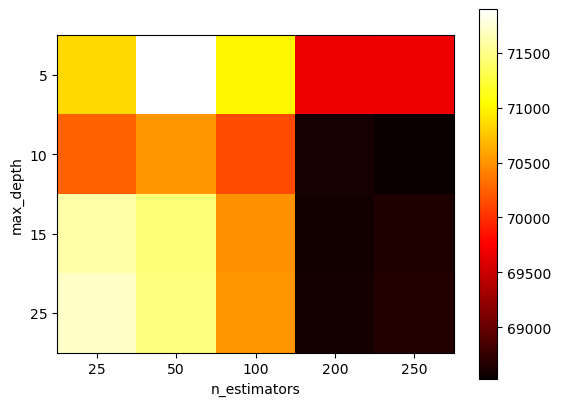

In [108]:
param_search = {
    'n_estimators': [25, 50, 100, 200, 250],
    'max_depth': [5, 10, 15, 25]
}

from sklearn.model_selection import ParameterGrid
grid = ParameterGrid(param_search)
rmse = []
for param in grid:
    print('fitting: ', param, end=' ')
    rmse.append(loocv_rf(X, y, **param))
    print('loss: ', rmse[-1])

rmse = np.array(rmse).reshape(len(param_search['max_depth']), len(param_search['n_estimators']))
plt.imshow(rmse, cmap='hot', interpolation='nearest')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(range(len(param_search['n_estimators'])), param_search['n_estimators'])
plt.yticks(range(len(param_search['max_depth'])), param_search['max_depth'])
plt.colorbar()
plt.show()



In [109]:
best_param = grid[np.argmin(rmse)]
print('best param: ', best_param)


best param:  {'n_estimators': 250, 'max_depth': 10}


In [110]:
model_final = RandomForestRegressor(n_estimators=best_param['n_estimators'], max_depth=best_param['max_depth'], random_state=0)
model_final.fit(X, y)
test = pd.read_csv('../data/cleandata/test_Zip_onehot.csv')
test['Zip_cluster_0'] = test['Zip_cluster_0'].apply(lambda x: 1 if x else 0)
test['Zip_cluster_1'] = test['Zip_cluster_1'].apply(lambda x: 1 if x else 0)
test_pred = model_final.predict(test)

In [115]:
test_out = pd.DataFrame({'ID': test['ID'], 'Outcome': test_pred})
test_out.to_csv('../data/predictions/RF_Zip_onehot.csv', index=False)
